In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

11490434/11490434 [==============================] - 0s 0us/step


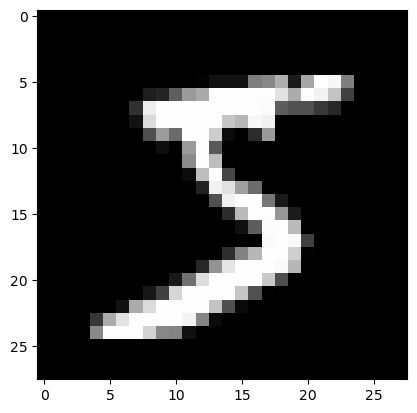

In [4]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train = (X_train - 127.5) / 127.5 #normalization

BUFFER = 60000
BATCH = 256

training_data = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER).batch(BATCH)
plt.imshow(X_train[0], cmap='gray')
plt.show()

In [5]:
def make_generator():
    model = tf.keras.Sequential() 
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) #noise as input
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1,1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False))

    return model
    

(1, 28, 28, 1)


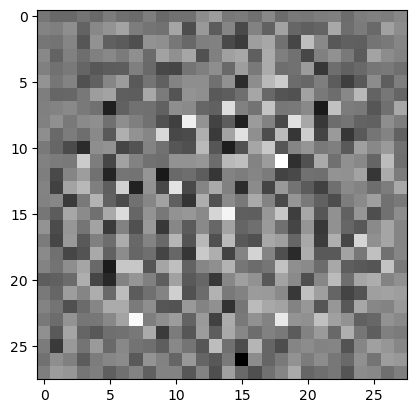

In [6]:
generator = make_generator()
noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)
print(generated_img.shape)
plt.imshow(generated_img[0,:,:,0], cmap='gray')

In [7]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model
    

In [8]:
discriminator = make_discriminator()
decision = discriminator(generated_img)
print(decision)

tf.Tensor([[0.00048814]], shape=(1, 1), dtype=float32)


In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real, fake):
    real_loss = cross_entropy(tf.ones_like(real), real)
    fake_loss = cross_entropy(tf.zeros_like(fake), fake)
    total_loss = real_loss+fake_loss
    return total_loss

In [11]:
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)


In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
EPOCHS = 50
noise_dim = 100
num = 16

seed = tf.random.normal([num, noise_dim])

@tf.function 
def train_step(images):
    noise = tf.random.normal([BATCH, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real = discriminator(images, training=True)
        fake = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake)
        disc_loss = discriminator_loss(real, fake)
        
    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))
    

In [14]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        
    display.clear_output(wait=True)

In [15]:
train(training_data, EPOCHS)

2023-06-30 00:10:52.622839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-30 00:11:06.412060: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Time for epoch 1 is 16.247275352478027 sec
Time for epoch 2 is 9.63402009010315 sec
Time for epoch 3 is 9.741007328033447 sec
Time for epoch 4 is 9.83860158920288 sec
Time for epoch 5 is 9.932392835617065 sec
Time for epoch 6 is 10.036332607269287 sec
Time for epoch 7 is 10.123594045639038 sec
Time for epoch 8 is 10.2288658618927 sec
Time for epoch 9 is 10.331785678863525 sec
Time for epoch 10 is 10.41377067565918 sec
Time for epoch 11 is 10.532912492752075 sec
Time for epoch 12 is 10.62228012084961 sec
Time for epoch 13 is 10.626984596252441 sec
Time for epoch 14 is 10.580293416976929 sec
Time for epoch 15 is 10.552077770233154 sec
Time for epoch 16 is 10.51437258720398 sec
Time for epoch 17 is 10.49864149093628 sec
Time for epoch 18 is 10.518301248550415 sec
Time for epoch 19 is 10.536373615264893 sec
Time for epoch 20 is 10.56242036819458 sec
Time for epoch 21 is 10.570679187774658 sec
Time for epoch 22 is 10.562432050704956 sec
Time for epoch 23 is 10.556178331375122 sec
Time for e

(1, 28, 28, 1)


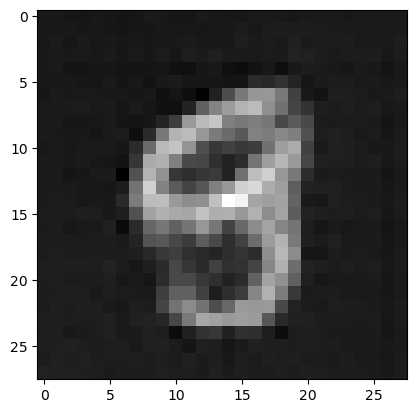

In [28]:

noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)
print(generated_img.shape)
plt.imshow(generated_img[0,:,:,0], cmap='gray')